# **Objective**: 
## Build a robust predictive model to estimate the `log_price` of homestay listings based on comprehensive analysis of their characteristics, amenities, and host information.
First make sure that the entire dataset is clean and ready to be used.

In [422]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

# data analysis and wrangling
import pandas as pd
import numpy as np

In [423]:
# import data
df = pd.read_csv('Homestays_Data.csv')

In [424]:
# preview data
# df.head() to check the first 5 rows
# df.tail() to check the last 5 rows
dfo = df.copy()
df.tail()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
74106,14549287,4.605170,Apartment,Private room,{},1,1.0,Real Bed,flexible,False,...,40.709025,-73.939405,one room bushwick,Williamsburg,0,NaN,https://a0.muscache.com/im/pictures/55162426/6...,11206,1.0,1.0
74107,13281809,5.043425,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,2.0,Real Bed,moderate,True,...,33.871549,-118.396053,Spacious Hermosa 2 BR on PCH,Hermosa Beach,16,93.0,https://a0.muscache.com/im/pictures/2b86560b-a...,90254,2.0,4.0
74108,18688039,5.220356,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",5,1.0,Real Bed,moderate,True,...,40.706749,-73.942377,Modern 2 Bedroom Apartment in Williamsburg,Williamsburg,43,94.0,https://a0.muscache.com/im/pictures/7fbe448c-5...,11206,2.0,2.0
74109,17045948,5.273000,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,1.0,Real Bed,strict,True,...,40.738535,-74.000157,Designer's Apartment in HEART of NYC,West Village,0,NaN,https://a0.muscache.com/im/pictures/b3971b63-0...,10011,0.0,2.0
74110,3534845,4.852030,Boat,Entire home/apt,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",4,1.0,Real Bed,moderate,False,...,33.761096,-118.192409,Cozy Boat at Shoreline Village,Long Beach,205,96.0,https://a0.muscache.com/im/pictures/22968537/d...,90802,1.0,2.0


In [425]:
# checking data types for various features
# dtypes: bool(1), float64(7), int64(3), object(18)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [426]:
# initial size
df.shape

(74111, 29)

In [427]:
'''
checking which features contain blank, null or empty values:
We can check for missing values with pandas isnull(). 
This indicates whether values are missing or not. 
Then we can sum all the values to check every column.
'''
# df.isnull().sum()
round((df.isnull().sum()/df.shape[0])*100,2)

id                         0.00
log_price                  0.00
property_type              0.00
room_type                  0.00
amenities                  0.00
accommodates               0.00
bathrooms                  0.27
bed_type                   0.00
cancellation_policy        0.00
cleaning_fee               0.00
city                       0.00
description                0.00
first_review              21.41
host_has_profile_pic       0.25
host_identity_verified     0.25
host_response_rate        24.69
host_since                 0.25
instant_bookable           0.00
last_review               21.36
latitude                   0.00
longitude                  0.00
name                       0.00
neighbourhood              9.27
number_of_reviews          0.00
review_scores_rating      22.56
thumbnail_url             11.09
zipcode                    1.30
bedrooms                   0.12
beds                       0.18
dtype: float64

In [428]:
# handling the null values: 
# drop the thumbnail_url and zipcode as they are not important factors

df = df.drop(columns='id')
df = df.drop(columns='name')
df = df.drop(columns='thumbnail_url')
df = df.drop(columns='zipcode')

# drop null rows whose observation columns having null values
df = df[~pd.isnull(df['bathrooms'])]
df = df[~pd.isnull(df['first_review'])]
df = df[~pd.isnull(df['host_has_profile_pic'])]
df = df[~pd.isnull(df['host_identity_verified'])]
df = df[~pd.isnull(df['host_since'])]
df = df[~pd.isnull(df['last_review'])]
df = df[~pd.isnull(df['neighbourhood'])]
df = df[~pd.isnull(df['bedrooms'])]
df = df[~pd.isnull(df['beds'])]

# dropping rows having less than 450 entries as it won't affect log_price much
df = df.groupby("property_type").filter(lambda x: len(x)>=450)

df.shape

(50753, 25)

In [429]:
# replacing unwanted symbols of object and converting to int64
df['host_response_rate'] = df['host_response_rate'].replace({'%':''}, regex=True)
df['host_response_rate'] = df['host_response_rate'].fillna(0)
df = df.astype({'host_response_rate': int})
df['host_response_rate']

0          0
1        100
2        100
4        100
5        100
        ... 
74097    100
74100    100
74103    100
74107    100
74108    100
Name: host_response_rate, Length: 50753, dtype: int32

In [430]:
'''
Inputing the missing values from past observations.
Again, “missingness” is almost always informative in itself, and you should tell your algorithm if a value was missing by reinforcing the patterns already provided by other features.
Mean imputation or Median imputations is used here.
Note: 
Mean imputation is suitable when the data is normally distributed and has no extreme outliers.
Median imputation is preferable when the data contains outliers or is skewed.
'''
# performing mean imputation for observations having % null between 9% and 25%
df = df.fillna(df.host_response_rate.mean())
df = df.fillna(df.review_scores_rating.mean())

df.shape

(50753, 25)

In [431]:
# recheck if the data is cleaned or not
# df.isnull().sum()
round((df.isnull().sum()/df.shape[0])*100,2)

log_price                 0.0
property_type             0.0
room_type                 0.0
amenities                 0.0
accommodates              0.0
bathrooms                 0.0
bed_type                  0.0
cancellation_policy       0.0
cleaning_fee              0.0
city                      0.0
description               0.0
first_review              0.0
host_has_profile_pic      0.0
host_identity_verified    0.0
host_response_rate        0.0
host_since                0.0
instant_bookable          0.0
last_review               0.0
latitude                  0.0
longitude                 0.0
neighbourhood             0.0
number_of_reviews         0.0
review_scores_rating      0.0
bedrooms                  0.0
beds                      0.0
dtype: float64

# 1. Feature Engineering:
# Task: Enhance the dataset by creating actionable and insightful features. 
Calculate `Host_Tenure` by determining the number of years from `host_since` to the current date, providing a measure of host experience. Generate `Amenities_Count` by counting the items listed in the `amenities` array to quantify property offerings. Determine `Days_Since_Last_Review` by calculating the days between `last_review` and today to assess listing activity and relevance.

In [432]:
# host and amenities features: 
# adding necessary columns
df.insert(0, 'host_tenure', 0)
df.insert(1, 'days_since_last_review', 0)

# df.insert(2, 'amenities_count', 0)
# enable_separate_amenities = 0

In [433]:
# Filling the added columns
today_date = pd.to_datetime(pd.to_datetime("today").date())

# host_tenure
df['host_since'] = pd.to_datetime(df['host_since'])
df['host_tenure'] = (today_date - df['host_since'])
df['host_tenure'] = df[['host_tenure']].apply(pd.to_numeric)
df['host_tenure'] = df['host_tenure']/(24*60*60*1e9)
df['host_tenure'] = df['host_tenure'].astype(int)

# days_since_last_review
df['last_review'] = pd.to_datetime(df['last_review'])
df['days_since_last_review'] = (today_date - df['last_review'])
df['days_since_last_review'] = df[['days_since_last_review']].apply(pd.to_numeric)
df['days_since_last_review'] = df['days_since_last_review']/(24*60*60*1e9)
df['days_since_last_review'] = df['days_since_last_review'].astype(int)


In [434]:
# extract amenities
# amenities_list = []
# for i in range(len(df['amenities'].unique())):
#     if not pd.isnull(df['amenities'].unique()[i]):
#         amenities = df['amenities'].unique()[i].split(",")
#         for ft in amenities:
#             if ft not in amenities_list:
#                 amenities_list.append(ft)
# amenities_list

In [435]:
# assign 0 to all the above amenities
# for i in range(len(amenities_list)):
#     ft = amenities_list[i]
#     df[ft] = 0

    
# if enable_separate_amenities == 1:
#     # assign 1 if those amenities are present
#     for i in range(len(df)):
#         idx = df.index[i]
#         amenities = dfo.loc[idx]["amenities"]
#         if not pd.isnull(amenities):
#             amenities = amenities.split(",")
#             for ft in amenities:
#                 df.at[idx, ft] = 1 

In [436]:
# dropping unecessary columns
df = df.drop(columns='amenities')
df = df.drop(columns='host_since')
df = df.drop(columns='first_review')
df = df.drop(columns='last_review')
df = df.drop(columns='neighbourhood')
df = df.drop(columns='description')
df.head()

,host_tenure,days_since_last_review,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
0,4424,2849,5.010635,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,...,t,t,0,f,40.696524,-73.991617,2,100.0,1.0,1.0
1,2513,2417,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,...,t,f,100,t,40.766115,-73.989040,6,93.0,3.0,3.0
2,2750,2426,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,...,t,t,100,t,40.808110,-73.943756,10,92.0,1.0,3.0
4,3354,2661,4.744932,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,...,t,t,100,t,38.925627,-77.034596,4,40.0,0.0,1.0
5,2525,2435,4.442651,Apartment,Private room,2,1.0,Real Bed,strict,True,...,t,t,100,t,37.753164,-122.429526,3,100.0,1.0,1.0


# 2. Exploratory Data Analysis (EDA):

## Task: Conduct a deep dive into the dataset to uncover underlying patterns and relationships. 
Analyze how pricing (`log_price`) correlates with both categorical (such as `room_type` and `property_type`) and numerical features (like `accommodates` and `number_of_reviews`). Utilize statistical tools and visualizations such as correlation matrices, histograms for distribution analysis, and scatter plots to explore relationships between variables.

In [437]:
import seaborn as sns
print(df.isnull().sum())
print(df.info)

host_tenure               0
days_since_last_review    0
log_price                 0
property_type             0
room_type                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
host_has_profile_pic      0
host_identity_verified    0
host_response_rate        0
instant_bookable          0
latitude                  0
longitude                 0
number_of_reviews         0
review_scores_rating      0
bedrooms                  0
beds                      0
dtype: int64
<bound method DataFrame.info of        host_tenure  days_since_last_review  log_price property_type  \
0             4424                    2849   5.010635     Apartment   
1             2513                    2417   5.129899     Apartment   
2             2750                    2426   4.976734     Apartment   
4             3354                    2661   4.744932     Apartment   
5           

In [438]:
# building the pearson correlation matrix to get the correlation values between different observations and log_price after performing encoding to convert string into int or float
''' 
Pearson correlation matrix¶
We use the Pearson correlation coefficient to examine the strength and direction of the linear relationship between two continuous variables.

The correlation coefficient can range in value from −1 to +1. The larger the absolute value of the coefficient, the stronger the relationship between the variables. For the Pearson correlation, an absolute value of 1 indicates a perfect linear relationship. A correlation close to 0 indicates no linear relationship between the variables.

The sign of the coefficient indicates the direction of the relationship. If both variables tend to increase or decrease together, the coefficient is positive, and the line that represents the correlation slopes upward. If one variable tends to increase as the other decreases, the coefficient is negative, and the line that represents the correlation slopes downward.
'''
# Extract categorical columns from the dataframe
# Here we extract the columns with object datatype as they are the categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()


   host_tenure  days_since_last_review  log_price  accommodates  bathrooms  \
0       4424.0                  2849.0   5.010635           3.0        1.0   
1       2513.0                  2417.0   5.129899           7.0        1.0   
2       2750.0                  2426.0   4.976734           5.0        1.0   
4       3354.0                  2661.0   4.744932           2.0        1.0   
5       2525.0                  2435.0   4.442651           2.0        1.0   

  cleaning_fee  host_response_rate   latitude   longitude  number_of_reviews  \
0         True                 0.0  40.696524  -73.991617                2.0   
1         True               100.0  40.766115  -73.989040                6.0   
2         True               100.0  40.808110  -73.943756               10.0   
4         True               100.0  38.925627  -77.034596                4.0   
5         True               100.0  37.753164 -122.429526                3.0   

   ...  city_DC  city_LA  city_NYC  city_SF  host_

<Axes: title={'center': 'Pearson Correlation Matrix (One-Hot Encoded)'}>

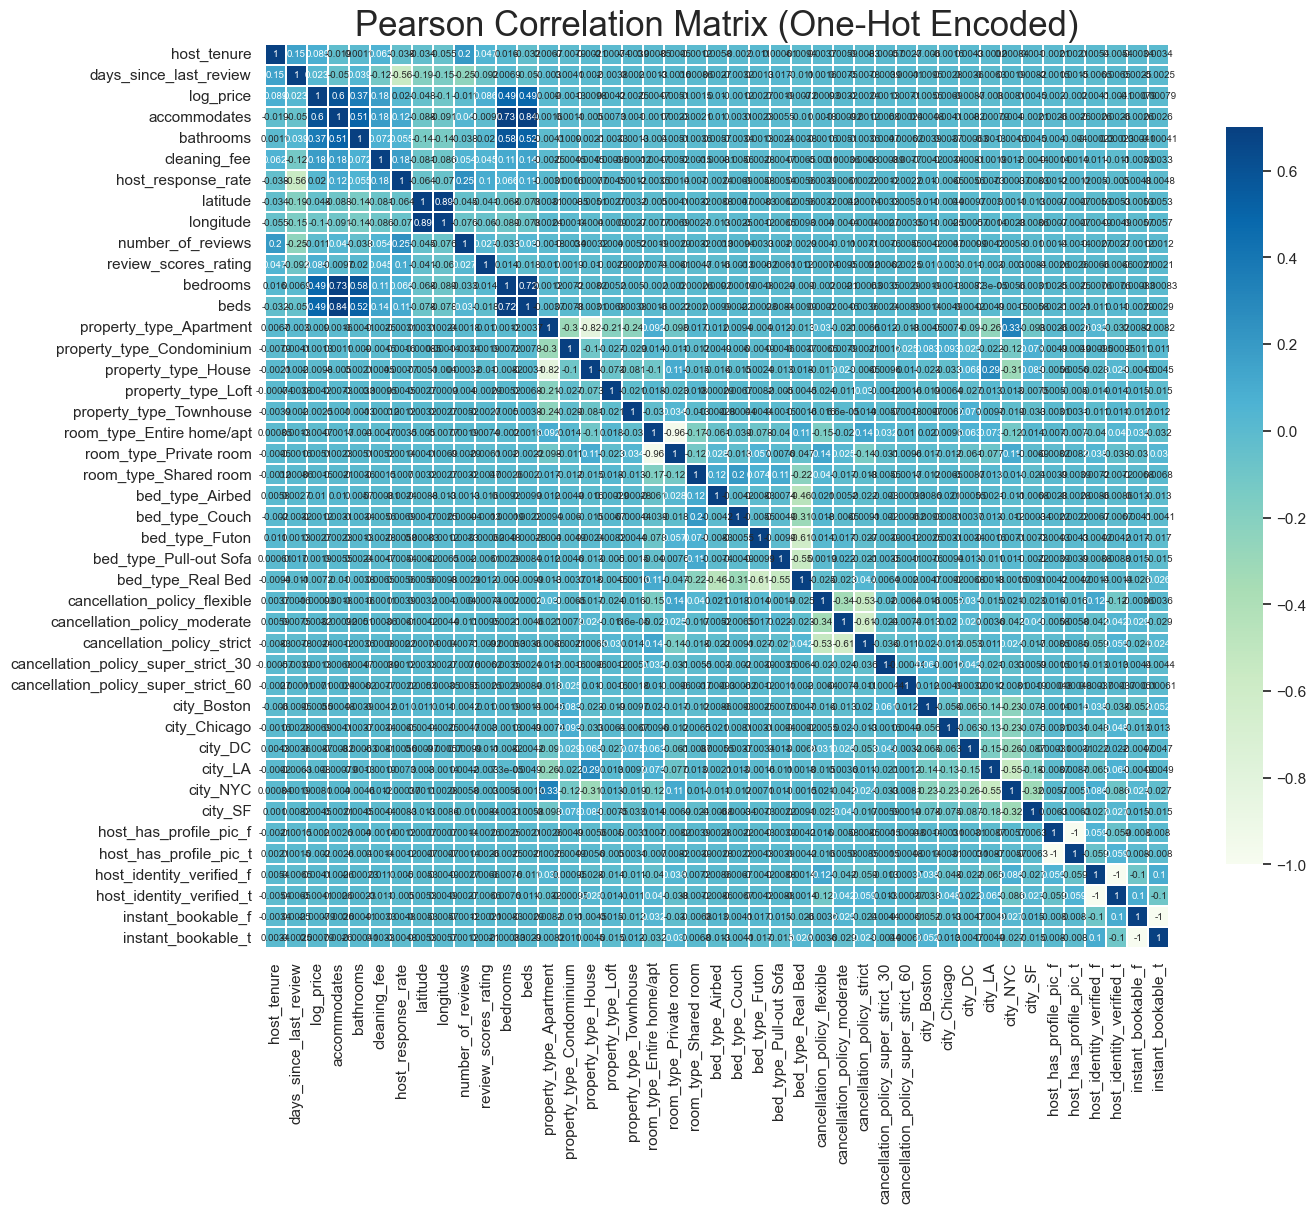

In [439]:
# performing one-hot-encoding
# Concatenate the one-hot encoded dataframe with the original dataframe
# Drop the original categorical columns (66748-15995 = 50753)
dfco = df.copy()
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(dfco[categorical_columns])
one_hot_dfco = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_columns))
dfco_encoded = pd.concat([dfco, one_hot_dfco], axis=1)
dfco_encoded = dfco_encoded.drop(categorical_columns, axis=1)
dfco = dfco_encoded[~pd.isnull(dfco_encoded)]
dfco.dropna()
print(dfco.head())

# print the pearson corr matrix
sns.set(style="whitegrid", font_scale=1)
plt.figure(figsize=(13,13))
plt.title('Pearson Correlation Matrix (One-Hot Encoded)',fontsize=25)
sns.heatmap(dfco.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="GnBu",linecolor='w',
            annot=True, annot_kws={"size":7}, cbar_kws={"shrink": .7})

# disadvantage becasue it adds on to more number of columns, hence interprating data becomes tougher and also the processing time increases

   host_tenure  days_since_last_review  log_price  property_type  room_type  \
0         4424                    2849   5.010635              0          0   
1         2513                    2417   5.129899              0          0   
2         2750                    2426   4.976734              0          0   
4         3354                    2661   4.744932              0          0   
5         2525                    2435   4.442651              0          1   

   accommodates  bathrooms  bed_type  cancellation_policy  cleaning_fee  ...  \
0             3        1.0         4                    2          True  ...   
1             7        1.0         4                    2          True  ...   
2             5        1.0         4                    1          True  ...   
4             2        1.0         4                    1          True  ...   
5             2        1.0         4                    2          True  ...   

   host_has_profile_pic  host_identity_verif

<Axes: title={'center': 'Pearson Correlation Matrix (Label Encoded)'}>

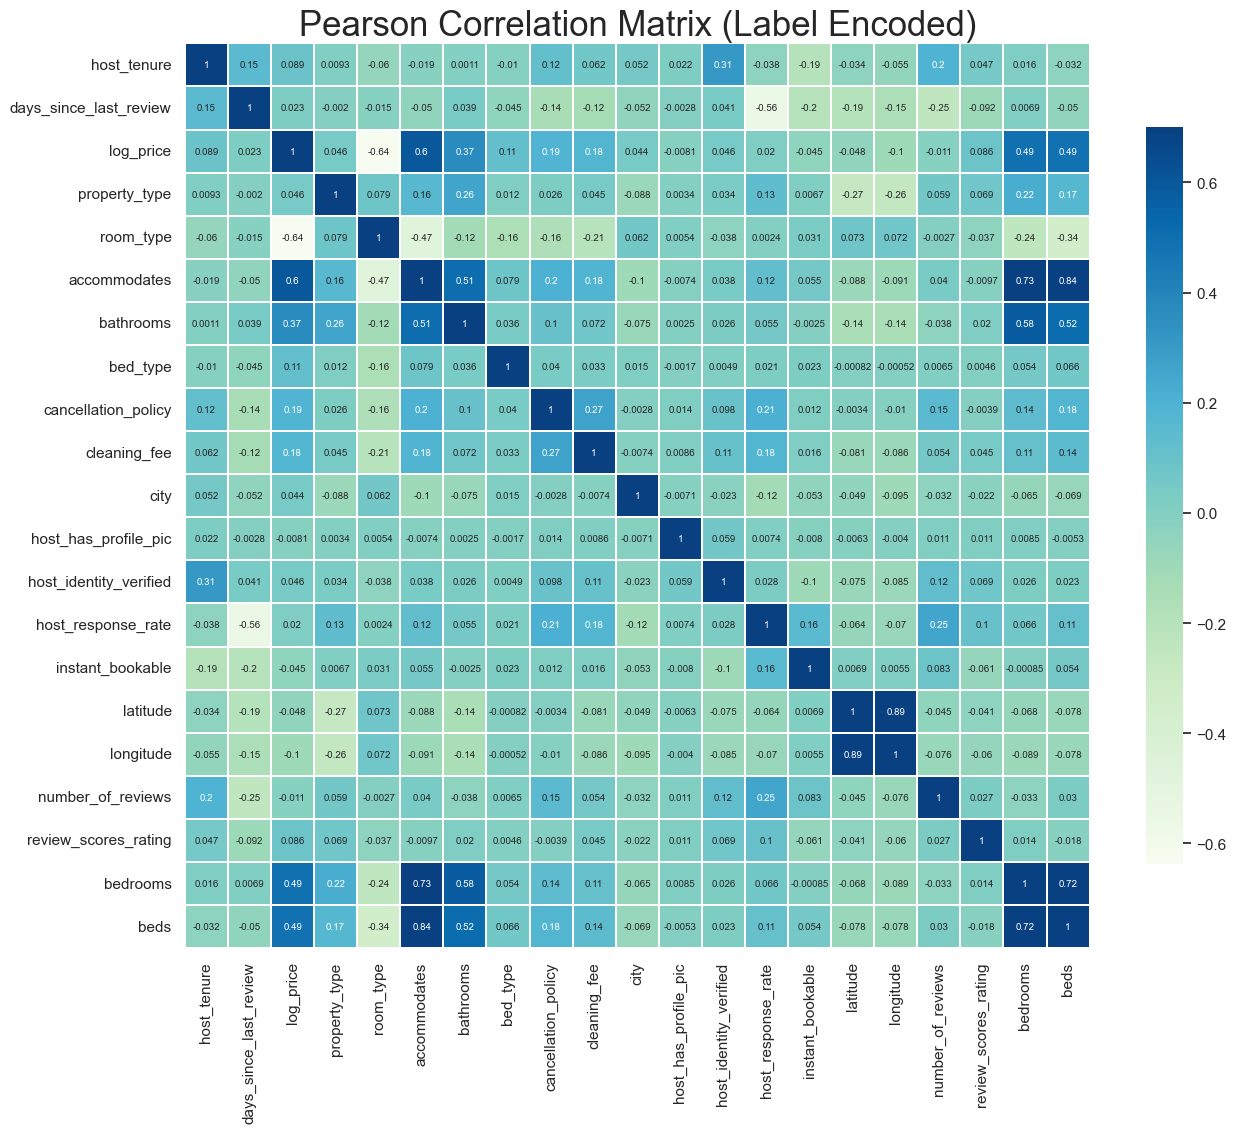

In [440]:
# performing label encoder
dfcl = df.copy()
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for column in categorical_columns:
    dfcl[column] = label_encoder.fit_transform(dfcl[column])
print(dfcl.head())

# print the pearson corr matrix
sns.set(style="whitegrid", font_scale=1)
plt.figure(figsize=(13,13))
plt.title('Pearson Correlation Matrix (Label Encoded)',fontsize=25)
sns.heatmap(dfcl.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="GnBu",linecolor='w',
            annot=True, annot_kws={"size":7}, cbar_kws={"shrink": .7})

# better to understand and compartively less complex appearing than than the one hot encoded pearson matrix

In [441]:
''' 
Univariate analysis:
Is used to explore each variable in a data set, separately. It looks at the range of values, as well as the central tendency of the values. It describes the pattern of response to the variable. It describes each variable on its own. Descriptive statistics describe and summarize data.
'''
# here done with Histograms
# based on city with property_type, room_type

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib
font = {'family':'Georgia', 'weight':'normal', 'size':14}
matplotlib.rc('font', **font)
df.columns

Index(['host_tenure', 'days_since_last_review', 'log_price', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bed_type',
       'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'instant_bookable',
       'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating',
       'bedrooms', 'beds'],
      dtype='object')

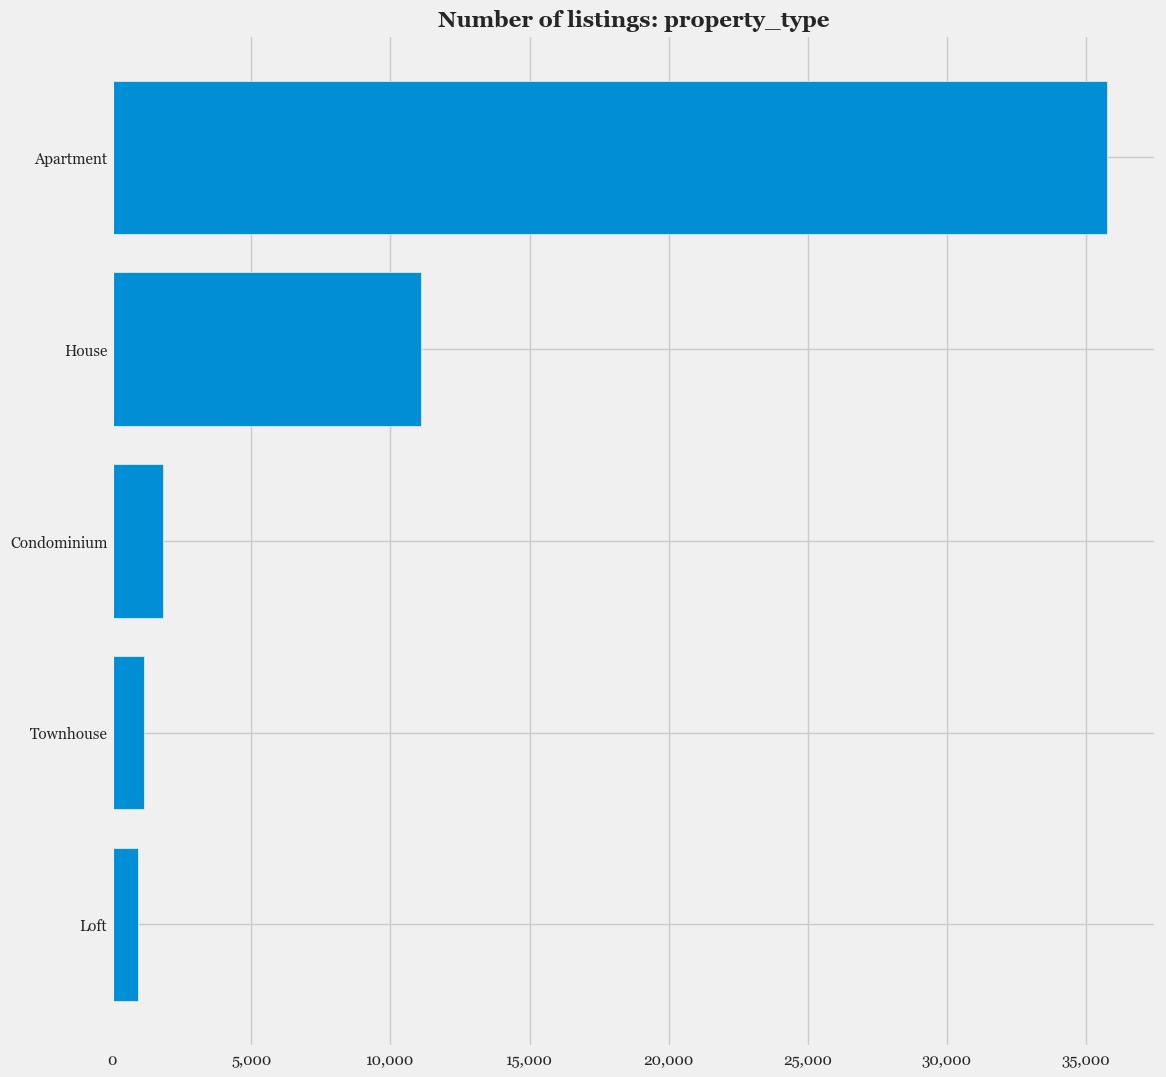

In [442]:
''' 
number of room listings preferences with the property_types which shows that nost preference goes to the apartment in majority of the cities with very very few importances given to exotic types i.e. near 0 preferences (not by mass number of people)
'''

dfp = df.groupby("property_type").count()["city"].reset_index().sort_values("city", ascending=False)
plt.figure(figsize=(12,12.5))
plt.barh(dfp["property_type"], dfp["city"])
ax = plt.gca()
ax.invert_yaxis()
plt.title("Number of listings: property_type", fontsize=16, fontweight="bold") 
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

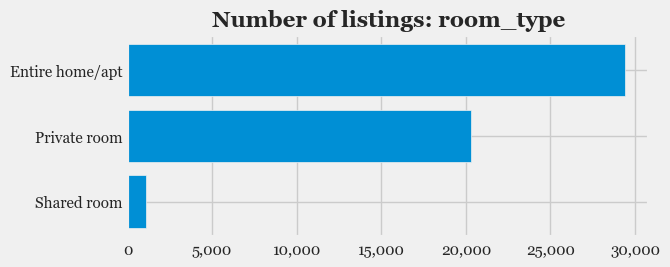

In [443]:
'''
number of room listings preferences with the room_types which shows that nost preference goes to the entire apartment in majority of the cities
'''
dfr = df.groupby("room_type").count()["city"].reset_index().sort_values("city", ascending=False)
plt.figure(figsize=(6,2.5))
plt.barh(dfr["room_type"], dfr["city"])
ax = plt.gca()
ax.invert_yaxis()
plt.title("Number of listings: room_type", fontsize=16, fontweight="bold") 
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [444]:
# Bivariate analysis: refers to the analysis of two variables to determine relationships between them.
''' 
here correlation with log_price is performed with:
# categorical features: 
    log_price & property_type
    log_price & room_type
    log_price & bed_type
    log_price & city
    log_price & neighbourhood -> removed

# numerical features:
    log_price & accomodates
    log_price & bathrooms
    log_price & number_of_reviews
    log_price & review_scores_rating
    log_price & bedrooms
    log_price & beds
    log_price & amenities -> removed

# host features:
    log_price & host_has_profile_pic
    log_price & host_identity_verified
    log_price & host_response_rate
    log_price & instant_bookable

'''

' \nhere correlation with log_price is performed with:\n# categorical features: \n    log_price & property_type\n    log_price & room_type\n    log_price & bed_type\n    log_price & city\n    log_price & neighbourhood -> removed\n\n# numerical features:\n    log_price & accomodates\n    log_price & bathrooms\n    log_price & number_of_reviews\n    log_price & review_scores_rating\n    log_price & bedrooms\n    log_price & beds\n    log_price & amenities -> removed\n\n# host features:\n    log_price & host_has_profile_pic\n    log_price & host_identity_verified\n    log_price & host_response_rate\n    log_price & instant_bookable\n\n'

['Entire home/apt' 'Private room' 'Shared room']


Text(0.5, 0.98, 'Boxplot: Listing Price by property_type')

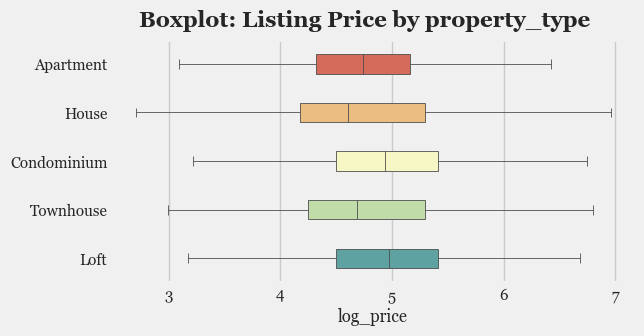

In [445]:
## categorical features:
    # log_price & property_type
    # log_price & room_type
    # log_price & bed_type
    # log_price & city
    # log_price & neighbourhood 

# correlation between log_price and property_type
print(df['room_type'].unique())
plt.figure(figsize=(6, 3))
dft = df[['property_type', 'log_price']]
sns.boxplot(x='log_price', y='property_type', data=dft, order=['Apartment', 'House', 'Condominium', 'Townhouse', 'Loft'], showfliers = False, palette='Spectral', linewidth=0.6, width=0.4)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle('Boxplot: Listing Price by property_type', fontweight='bold', fontsize=16)

['Apartment' 'Condominium' 'House' 'Loft' 'Townhouse']


Text(0.5, 0.98, 'Boxplot: Listing Price by room_type')

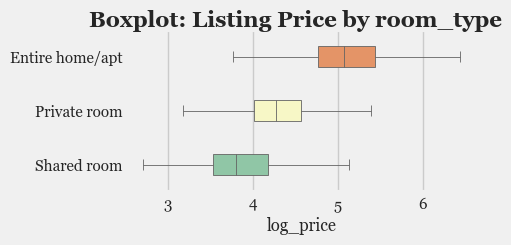

In [446]:
# correlation between log_price and room_type
print(df['property_type'].unique())
plt.figure(figsize=(4, 2))
dft = df[['room_type', 'log_price']]
sns.boxplot(x='log_price', y='room_type', data=dft, order=['Entire home/apt', 'Private room', 'Shared room'], showfliers = False, palette='Spectral', linewidth=0.6, width=0.4)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle('Boxplot: Listing Price by room_type', fontweight='bold', fontsize=16)

['Real Bed' 'Futon' 'Pull-out Sofa' 'Couch' 'Airbed']


Text(0.5, 0.98, 'Boxplot: Listing Price by bed_type')

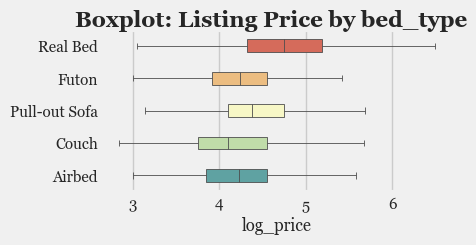

In [447]:
# correlation between log_price and bed_type
print(df['bed_type'].unique())
plt.figure(figsize=(4, 2))
dft = df[['bed_type', 'log_price']]
sns.boxplot(x='log_price', y='bed_type', data=dft, order=['Real Bed', 'Futon', 'Pull-out Sofa', 'Couch', 'Airbed'], showfliers = False, palette='Spectral', linewidth=0.6, width=0.4)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle('Boxplot: Listing Price by bed_type', fontweight='bold', fontsize=16)

['NYC' 'DC' 'SF' 'LA' 'Chicago' 'Boston']


Text(0.5, 0.98, 'Boxplot: Listing Price by city')

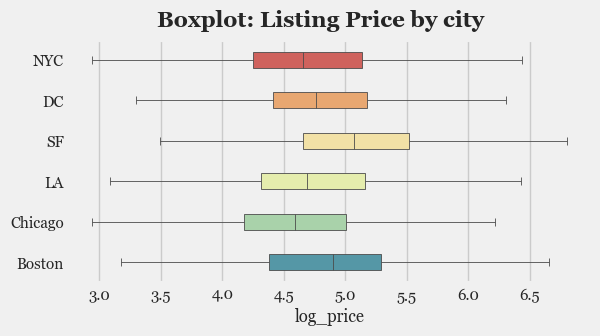

In [448]:
# correlation between log_price and city
print(df['city'].unique())
plt.figure(figsize=(6, 3))
dft = df[['city', 'log_price']]
sns.boxplot(x='log_price', y='city', data=dft, order=['NYC', 'DC', 'SF', 'LA', 'Chicago', 'Boston'], showfliers = False, palette='Spectral', linewidth=0.6, width=0.4)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle('Boxplot: Listing Price by city', fontweight="bold", fontsize=16)

In [449]:
# # correlation between log_price and neighbourhood
# print(df['neighbourhood'].unique())
# # too many differnet neighbourhoods, hence not much insightful about the tendency of the host to reside can be concluded from here

In [450]:
new_df = pd.DataFrame(dfcl.corr(method="pearson")["log_price"])
new_df.reset_index(inplace=True)
new_df.columns = ["features", "correlation_with_price"]
new_df.sort_values("correlation_with_price", ascending=False)
df1 = new_df[new_df["correlation_with_price"] > 0.1]
corr_features = df1["features"].values
corr_features.tolist().append("log_price")
df1.drop([2], inplace=True)
df1

,features,correlation_with_price
5,accommodates,0.596466
6,bathrooms,0.368188
7,bed_type,0.114874
8,cancellation_policy,0.191205
9,cleaning_fee,0.179416
19,bedrooms,0.492308
20,beds,0.489918


Text(0.5, 0.98, 'Number of people accomodated  [Correlation: 0.596]')

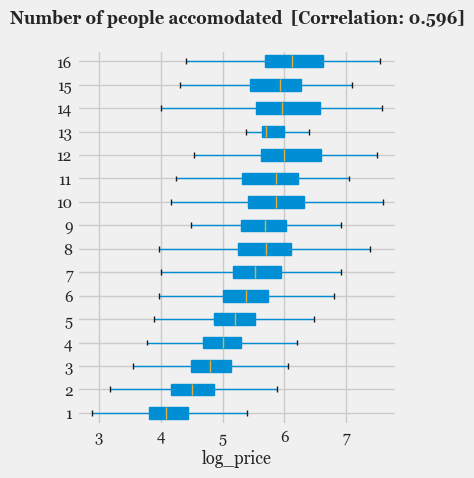

In [451]:
## numerical features:
    # log_price & accomodates
    # log_price & bathrooms
    # log_price & number_of_reviews
    # log_price & review_scores_rating
    # log_price & bedrooms
    # log_price & beds
    # log_price & amenities -> ***need to figure out***

# for correlation between log_price and no. of people accomodated
col = 'accommodates'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Number of people accomodated  [Correlation: " + str(cov) + "]"
plt_name = "accommodates"

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Number of Bathrooms  [Correlation: 0.368]')

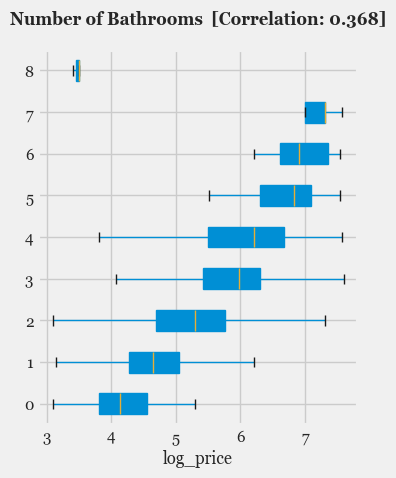

In [452]:
# for correlation between log_price and no. of bathrooms
col = 'bathrooms'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Number of Bathrooms  [Correlation: " + str(cov) + "]"
plt_name = 'bathrooms'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

In [453]:
# for correlation between log_price and no. of people accomodated
print(df['number_of_reviews'].unique())
print(df['review_scores_rating'].unique())
# these columns are too wide varitied to be spatially bivariated , hence use diff plot

[  2   6  10   4   3   9 159  82  29  13  15  12  26   5  57  73  14  40
   1 248  17 138  11  44  34  85  18  31  30  19  25  22  23  28   7  32
 144  16  38 105  59  67  21  61  87 206   8  43 104  47 186  36  27 167
  48 102  51 126  81  72  58  79  63  78  55  54  52  42  75 128  60  90
 254 135  64 191  24  66 139 125 129  74 318  33 187  35  37  20  70  39
  46  83  45  41  49 289 190  62  88 127 154 118 136  69 314 112  77  56
 181  99  53 117 101 106 255 114 110 192  76 113  91 123  84 146 119  86
  50  71 157  95 158 142  97 194 173 122 132 171  68 111 161 208 131 384
 216 133 116 148  89 156 179 147 145 202 150 258 120  98 178 200 155 163
 149 107  94 267 100  65 207 172 121 180  80  92 263 193 251 199 103 166
 237 290 137 153  96 425 185 140 168 162  93 360 141 246 195 196 109 273
 305 214 351 152 189 269 134 221 317 218 217 336 272 175 143 215 188 278
 383 160 203 165 115 108 256 198 323 465 302 469 220 204 170 182 480 287
 225 492 224 201 288 389 343 303 169 228 236 205 28

Text(0.5, 0, 'log_price')

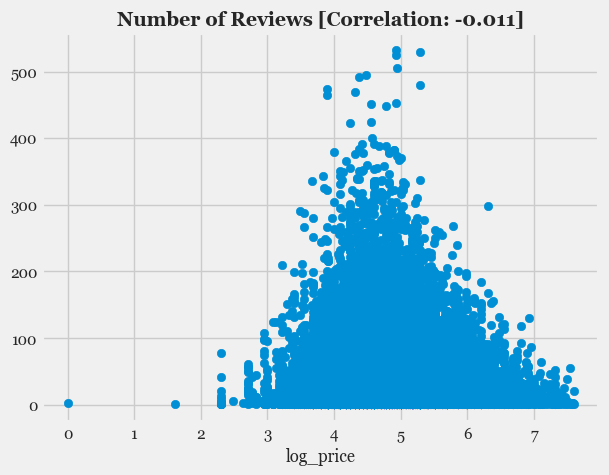

In [454]:
# for correlation between log_price and number_of_reviews
col = 'number_of_reviews'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
title = "Number of Reviews [Correlation: " + str(cov) + "]"
plt_name = 'number_of_reviews'

plt.scatter(dfcl['log_price'], df[col])
ax = plt.gca()
plt.title(title, fontsize=14, fontweight='bold') 
ax.set_xlabel('log_price', fontsize=12)

Text(0.5, 0, 'log_price')

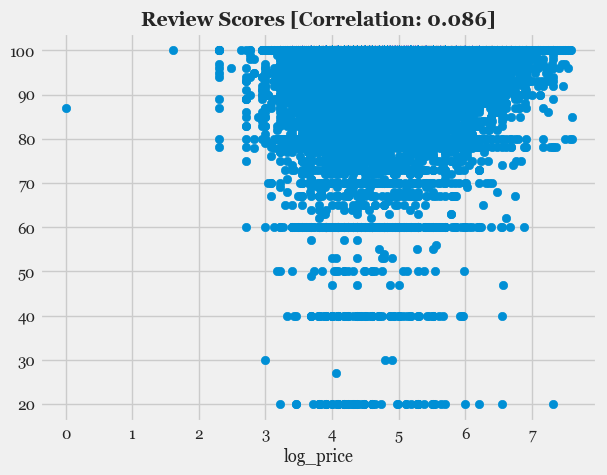

In [455]:
# for correlation between log_price and review_scores_rating
col = 'review_scores_rating'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
title = "Review Scores [Correlation: " + str(cov) + "]"
plt_name = 'review_scores_rating'

plt.scatter(dfcl['log_price'], df[col])
ax = plt.gca()
plt.title(title, fontsize=14, fontweight='bold') 
ax.set_xlabel('log_price', fontsize=12)

Text(0.5, 0.98, 'Number of Bedrooms  [Correlation: 0.492]')

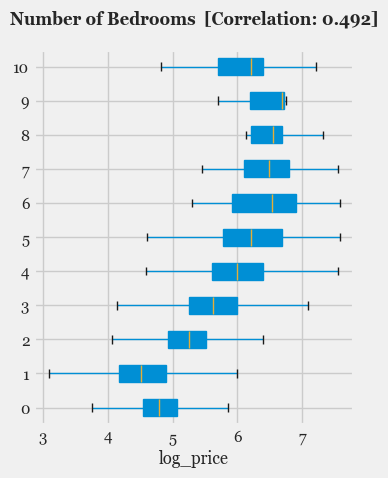

In [456]:
# for correlation between log_price and no. of bedrooms
col = 'bedrooms'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Number of Bedrooms  [Correlation: " + str(cov) + "]"
plt_name = 'bedrooms'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Beds [Correlation: 0.49]')

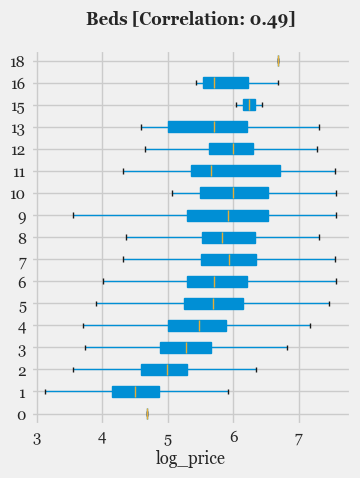

In [457]:
# for correlation between log_price and no. of beds
col = 'beds'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Beds [Correlation: " + str(cov) + "]"
plt_name = 'beds'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Host Has Profile Pic  [Correlation: -0.008]')

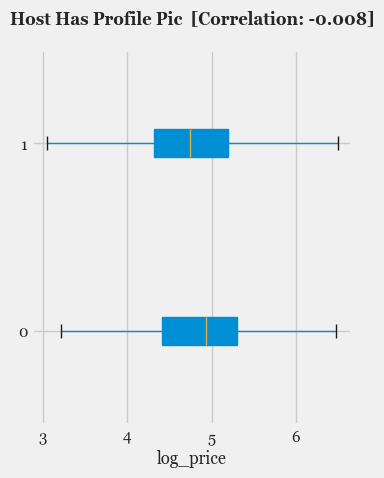

In [458]:
# host features:
    # log_price & host_has_profile_pic
    # log_price & host_identity_verified
    # log_price & host_response_rate
    # log_price & instant_bookable
# 
# for correlation between log_price and host_has_profile_pic
col = 'host_has_profile_pic'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Host Has Profile Pic  [Correlation: " + str(cov) + "]"
plt_name = 'host_has_profile_pic'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Host Identity Verified  [Correlation: 0.046]')

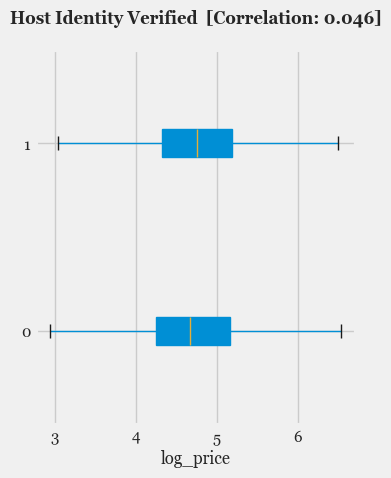

In [459]:
# for correlation between log_price and host_identity_verified
col = 'host_identity_verified'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Host Identity Verified  [Correlation: " + str(cov) + "]"
plt_name = 'host_identity_verified'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Host Instant Bookable  [Correlation: -0.045]')

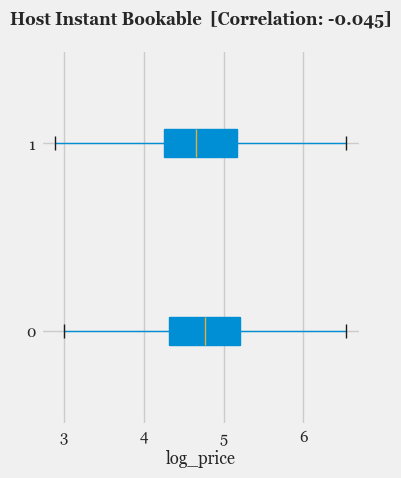

In [460]:
# for correlation between log_price and instant_bookable
col = 'instant_bookable'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Host Instant Bookable  [Correlation: " + str(cov) + "]"
plt_name = 'instant_bookable'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

[  0 100  71  68  67  90  86  92  82  80  89  93  99  50  70  91  25  96
  95  98  62  88  29  81  63  38  60  79  75  65  94  97  87  40  33  58
  76  83  30  64  17  20  77  53  78  54  73  41  57  85  56  42  44  14
  10  72  84  55  43  74  36  39  46  26  61  59  52  22  15  69  27  11
  35  31  21  47  66]


Text(0.5, 0, 'log_price')

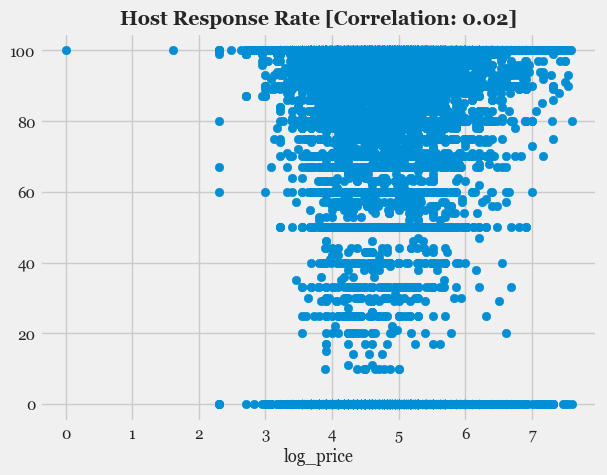

In [461]:
# for correlation between log_price and instant_bookable
print(df['host_response_rate'].unique())
# these columns are too wide varitied to be spatially bivariated , hence use diff plot
col = 'host_response_rate'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
title = "Host Response Rate [Correlation: " + str(cov) + "]"
plt_name = 'host_response_rate'

plt.scatter(dfcl['log_price'], df[col])
ax = plt.gca()
plt.title(title, fontsize=14, fontweight='bold') 
ax.set_xlabel('log_price', fontsize=12)